In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import random
from Critic import Critic
from Actor import Actor
from Buffer import ReplayBuffer
import matplotlib.pyplot as plt

In [2]:
policy_net = Actor(3,1,2).to("cuda")   # makes the decision
policy_target = Actor(3,1,2).to("cuda")

value_net = Critic(3,1).to("cuda")
value_target = Critic(3,1).to("cuda")

In [3]:
actor_optimizer = optim.Adam(policy_net.parameters())
critic_optimizer = optim.Adam(value_net.parameters())
env = gym.make('Pendulum-v1', g=9.81)
policy_target.load_state_dict(policy_net.state_dict())
value_target.load_state_dict(value_net.state_dict())
replay_buffer = ReplayBuffer()

In [4]:
tau = 0.005
discount = 0.99
batch_size = 64
episode_num = 500
step_per_episode = 200
expl_noise = 0.1
episode_rewards=[]

Episode: 1, Reward: -1483.844499307688
Episode: 2, Reward: -1556.1673199165346
Episode: 3, Reward: -1618.0591371080347
Episode: 4, Reward: -1754.8969672864112
Episode: 5, Reward: -1621.7699793696681
Episode: 6, Reward: -1586.4183310890817
Episode: 7, Reward: -1648.5713065821276
Episode: 8, Reward: -1809.9562395194628
Episode: 9, Reward: -1707.9917672110855
Episode: 10, Reward: -1723.1614570960653
Episode: 11, Reward: -1641.126872182549
Episode: 12, Reward: -1383.0981339316925
Episode: 13, Reward: -1572.8406647030495
Episode: 14, Reward: -1589.4823733078165
Episode: 15, Reward: -1507.3745910576602
Episode: 16, Reward: -1470.9248217447691
Episode: 17, Reward: -1473.3341810339607
Episode: 18, Reward: -1635.8309400135347
Episode: 19, Reward: -1470.2695738031675
Episode: 20, Reward: -1617.7151961068666
Episode: 21, Reward: -1468.5329187873906
Episode: 22, Reward: -1715.219878532652
Episode: 23, Reward: -1493.7619080899976
Episode: 24, Reward: -1351.093877275266
Episode: 25, Reward: -1569.49

Episode: 202, Reward: -294.8401095437466
Episode: 203, Reward: -131.51094093239368
Episode: 204, Reward: -272.96899991082523
Episode: 205, Reward: -132.41575331225044
Episode: 206, Reward: -134.08334210332475
Episode: 207, Reward: -133.84000212618676
Episode: 208, Reward: -284.5394780207062
Episode: 209, Reward: -374.09393726287374
Episode: 210, Reward: -131.85212680736035
Episode: 211, Reward: -128.380920369566
Episode: 212, Reward: -129.3520837607331
Episode: 213, Reward: -130.84203653748634
Episode: 214, Reward: -0.2456858994042933
Episode: 215, Reward: -1.7960466606692507
Episode: 216, Reward: -132.0540917910363
Episode: 217, Reward: -262.2586580119571
Episode: 218, Reward: -384.76902897176365
Episode: 219, Reward: -124.86028758318393
Episode: 220, Reward: -129.47795256907102
Episode: 221, Reward: -309.911698944398
Episode: 222, Reward: -132.05393702995158
Episode: 223, Reward: -304.8891002072092
Episode: 224, Reward: -1491.6236146635651
Episode: 225, Reward: -132.67791357686417
Ep

Episode: 400, Reward: -251.41745803229
Episode: 401, Reward: -122.36015323314071
Episode: 402, Reward: -125.24072827975102
Episode: 403, Reward: -121.74894038348324
Episode: 404, Reward: -9.154317688071847
Episode: 405, Reward: -130.10295743071876
Episode: 406, Reward: -123.2801365777499
Episode: 407, Reward: -10.768528374075332
Episode: 408, Reward: -136.27071977318286
Episode: 409, Reward: -127.56030065196875
Episode: 410, Reward: -126.29508210372684
Episode: 411, Reward: -317.3948045867166
Episode: 412, Reward: -256.1411730374675
Episode: 413, Reward: -136.0924492790688
Episode: 414, Reward: -128.93039470520557
Episode: 415, Reward: -1.2232175399212584
Episode: 416, Reward: -132.28377869900757
Episode: 417, Reward: -126.51440654639293
Episode: 418, Reward: -121.86742275917396
Episode: 419, Reward: -130.44301756851138
Episode: 420, Reward: -131.78573781635242
Episode: 421, Reward: -250.92440044358273
Episode: 422, Reward: -247.86345848588815
Episode: 423, Reward: -0.33979273068359966

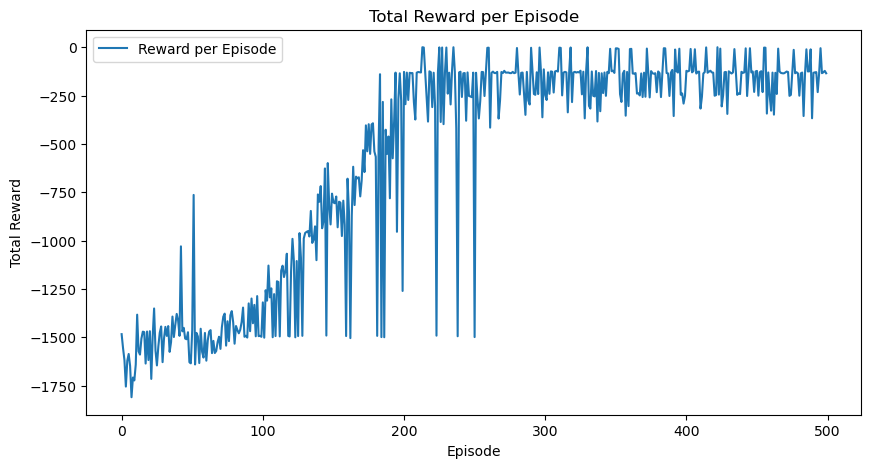

In [5]:
for episode in range(episode_num):
    state = env.reset()
    state = np.array(state[0])
    total_reward = 0
    transition_count = 0
    
    for step in range(step_per_episode):
        state_tensor = torch.FloatTensor(state.reshape(1, -1)).to("cuda")    # reshape the array into one row 
        action = policy_net(state_tensor).cpu().data.numpy().flatten()
        noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])   # Added some noise to avoid from trapping into sub-optimal
        action = (action + noise).clip(env.action_space.low, env.action_space.high) # Guarantee the value inside of the boundary
        transition_count += 1
        
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.add((state, next_state, action, reward, done))

        if len(replay_buffer.storage) > batch_size:
            # Sample replay buffer
            batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state_batch = torch.FloatTensor(batch_states).to("cuda")
            next_state_batch = torch.FloatTensor(batch_next_states).to("cuda")
            action_batch = torch.FloatTensor(batch_actions).to("cuda")
            reward_batch = torch.FloatTensor(batch_rewards).unsqueeze(1).to("cuda")
            done_batch = torch.FloatTensor(batch_dones).unsqueeze(1).to("cuda")

            # Compute the target Q value
            target_Q = value_target(next_state_batch, policy_target(next_state_batch)).to("cuda")
            target_Q = reward_batch + ((1 - done_batch) * discount * target_Q).detach()

            # Get current Q estimate
            current_Q = value_net(state_batch, action_batch)

            # Compute critic loss
            critic_loss = nn.MSELoss()(current_Q, target_Q)

            # Optimize the critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Compute actor loss
            actor_loss = -value_net(state_batch, policy_net(state_batch)).mean()
            
            # Optimize the actor
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            if transition_count % 20 ==0:
                # Update the frozen target models
                for param, target_param in zip(value_net.parameters(), value_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                
                for param, target_param in zip(policy_net.parameters(), policy_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


        state = next_state
        total_reward += reward
        
        if done:
            break
            
    episode_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Reward: {total_reward}")
    
plt.figure(figsize=(10, 5))
plt.plot(range(len(episode_rewards)), episode_rewards, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.savefig('episode_rewards1.png')
plt.show()

env.close()
torch.save(policy_net.state_dict(), 'policy_net_model1.pth')